In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline 

In [2]:
train = pd.read_csv('train.csv') 
test = pd.read_csv('test.csv') 

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.shape

(891, 12)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
train.isnull().sum() #Look For null values in the training dataset

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Visualizing the data to get a better understanding

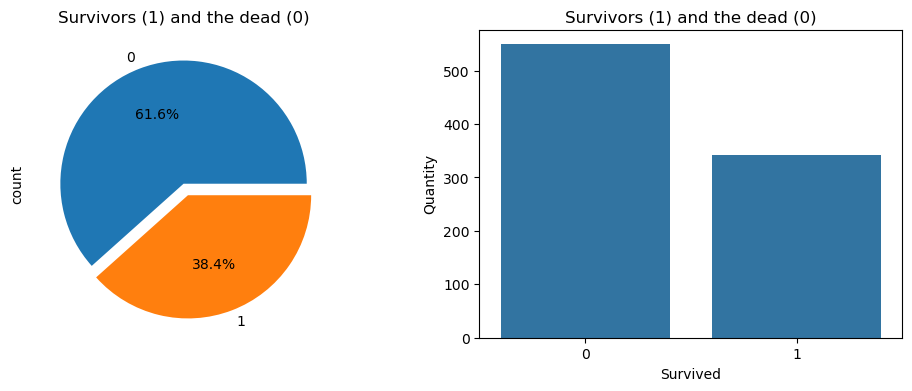

In [7]:
f, ax = plt.subplots(1, 2, figsize=(12, 4)) 
train['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0]) 
ax[0].set_title('Survivors (1) and the dead (0)') 

sns.countplot(x = 'Survived', data=train, ax=ax[1]) 
ax[1].set_ylabel('Quantity') 
ax[1].set_title('Survivors (1) and the dead (0)') 
plt.show()


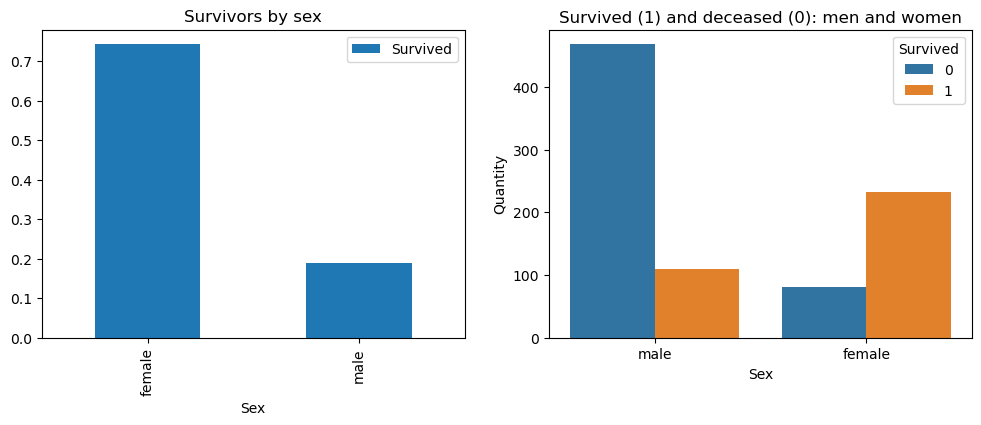

In [8]:
f, ax = plt.subplots(1,2,figsize=(12, 4)) 
train[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0]) 
ax[0].set_title('Survivors by sex') 

sns.countplot(x = 'Sex', hue='Survived', data=train, ax=ax[1]) 
ax[1].set_ylabel('Quantity') 
ax[1].set_title('Survived (1) and deceased (0): men and women') 
plt.show()

# Feature Engineering

Now we just eliminate some features from the datasets which will not have any impact on out model

In [9]:
train = train.drop(['Cabin'], axis=1) 
test = test.drop(['Cabin'], axis=1)

In [10]:
train = train.drop(['Ticket'], axis=1) 
test = test.drop(['Ticket'], axis=1) 

Replace the Null values in the embark column with 'S'

In [11]:

train = train.fillna({"Embarked": "S"})  

sort the ages into logical categories 

In [12]:
train["Age"] = train["Age"].fillna(-0.5) 
test["Age"] = test["Age"].fillna(-0.5) 
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf] 
labels = ['Unknown', 'Baby', 'Child', 'Teenager', 
          'Student', 'Young Adult', 'Adult', 'Senior'] 
train['AgeGroup'] = pd.cut(train["Age"], bins, labels=labels) 
test['AgeGroup'] = pd.cut(test["Age"], bins, labels=labels) 

Combine both the train and test dataset together

In [13]:
combine = [train, test] 

extract a title for each Name & replace with more common names

In [14]:
for dataset in combine: 
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False) 
  
pd.crosstab(train['Title'], train['Sex']) 

for dataset in combine: 
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Capt', 'Col', 
                                                 'Don', 'Dr', 'Major', 
                                                 'Rev', 'Jonkheer', 'Dona'], 
                                                'Rare') 
  
    dataset['Title'] = dataset['Title'].replace( 
        ['Countess', 'Lady', 'Sir'], 'Royal') 
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss') 
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss') 
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs') 
  
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean() 

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.285714
5,Royal,1.000000


map each of the title groups to a numerical value 

In [15]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, 
                 "Master": 4, "Royal": 5, "Rare": 6} 
for dataset in combine: 
    dataset['Title'] = dataset['Title'].map(title_mapping) 
    dataset['Title'] = dataset['Title'].fillna(0) 

As we saw earlier the age col has som missing values so this can be hep to fil in that information

In [16]:
mr_age = train[train["Title"] == 1]["AgeGroup"].mode() # Young Adult 
miss_age = train[train["Title"] == 2]["AgeGroup"].mode() # Student 
mrs_age = train[train["Title"] == 3]["AgeGroup"].mode() # Adult 
master_age = train[train["Title"] == 4]["AgeGroup"].mode() # Baby 
royal_age = train[train["Title"] == 5]["AgeGroup"].mode() # Adult 
rare_age = train[train["Title"] == 6]["AgeGroup"].mode() # Adult 

age_title_mapping = {1: "Young Adult", 2: "Student", 3: "Adult", 4: "Baby", 5: "Adult", 6: "Adult"} 

for x in range(len(train["AgeGroup"])): 
	if train["AgeGroup"][x] == "Unknown": 
		train["AgeGroup"][x] = age_title_mapping[train["Title"][x]] 

for x in range(len(test["AgeGroup"])): 
	if test["AgeGroup"][x] == "Unknown": 
		test["AgeGroup"][x] = age_title_mapping[test["Title"][x]] 


In [17]:
# map each Age value to a numerical value 
age_mapping = {'Baby': 1, 'Child': 2, 'Teenager': 3, 
			'Student': 4, 'Young Adult': 5, 'Adult': 6, 
			'Senior': 7} 
train['AgeGroup'] = train['AgeGroup'].map(age_mapping) 
test['AgeGroup'] = test['AgeGroup'].map(age_mapping) 

train.head() 

# dropping the Age feature for now, might change 
train = train.drop(['Age'], axis=1) 
test = test.drop(['Age'], axis=1) 


We droped age feature after mapping and now we can also drop name feature.

In [18]:
train = train.drop(['Name'], axis=1) 
test = test.drop(['Name'], axis=1) 

Assign numerical values to sex and embarks

In [19]:
sex_mapping = {"male": 0, "female": 1} 
train['Sex'] = train['Sex'].map(sex_mapping) 
test['Sex'] = test['Sex'].map(sex_mapping) 
  
embarked_mapping = {"S": 1, "C": 2, "Q": 3} 
train['Embarked'] = train['Embarked'].map(embarked_mapping) 
test['Embarked'] = test['Embarked'].map(embarked_mapping) 

Now we fill in the missing Fare value in the test and then we will drop it

In [20]:
for x in range(len(test["Fare"])): 
	if pd.isnull(test["Fare"][x]): 
		pclass = test["Pclass"][x] # Pclass = 3 
		test["Fare"][x] = round( 
			train[train["Pclass"] == pclass]["Fare"].mean(), 4) 

# map Fare values into groups of numerical values 
train['FareBand'] = pd.qcut(train['Fare'], 4, labels=[1, 2, 3, 4]) 
test['FareBand'] = pd.qcut(test['Fare'], 4, labels=[1, 2, 3, 4]) 

# drop Fare values 
train = train.drop(['Fare'], axis=1) 
test = test.drop(['Fare'], axis=1) 


C:\Users\Sanket Dalvi\AppData\Local\Temp\ipykernel_10892\2536234658.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Fare"][x] = round(


In [21]:
train.shape

(891, 10)

In [22]:
train.head(10)

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Embarked,AgeGroup,Title,FareBand
0,1,0,3,0,1,0,1,4.0,1,1
1,2,1,1,1,1,0,2,6.0,3,4
2,3,1,3,1,0,0,1,5.0,2,2
3,4,1,1,1,1,0,1,5.0,3,4
4,5,0,3,0,0,0,1,5.0,1,2
5,6,0,3,0,0,0,3,5.0,1,2
6,7,0,1,0,0,0,1,6.0,1,4
7,8,0,3,0,3,1,1,1.0,4,3
8,9,1,3,1,0,2,1,5.0,3,2
9,10,1,2,1,1,0,2,3.0,3,3


# Model Training

In [27]:
from sklearn.model_selection import train_test_split 

# Drop the Survived and PassengerId 
# column from the trainset 
predictors = train.drop(['Survived', 'PassengerId'], axis=1) 
target = train["Survived"] 
x_train, x_val, y_train, y_val = train_test_split( 
	predictors, target, test_size=0.2, random_state=0) 


In [28]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score 

rf = RandomForestClassifier() 

# Fit the training data along with its output 
rf.fit(x_train, y_train) 
y_pred = rf.predict(x_val) 

# Find the accuracy score of the model 
randomforest = round(accuracy_score(y_pred, y_val) * 100, 2) 
print(randomforest) 


84.92


We have succesfully trained the model and got an accuracy score of 85%

# Model Prediction

Now we will feed the model with the test data and the prediction made by the model will be saved in the CSV file.

In [29]:
ids = test['PassengerId'] 
predictions = rf.predict(test.drop('PassengerId', axis=1)) 

output = pd.DataFrame({'PassengerId': ids, 'Survived': predictions}) 
output.to_csv('resultfile.csv', index=False) 


In [31]:
df = pd.read_csv('resultfile.csv')

In [37]:
df.head(20)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0
